<a href="https://colab.research.google.com/github/nnanna217/msc-image-search/blob/main/indexer_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers pinecone-client tqdm

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    'SaffalPoosh/deepFashion-with-masks',
    'full_size',
    split='train[:20000]',
    ignore_verifications=False  # set to True if seeing splits Error
)
dataset

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1760: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/40658 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/SaffalPoosh___parquet/SaffalPoosh--deepFashion-with-masks-a0eed9d198c6a6ba/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Dataset({
    features: ['images', 'gender', 'pose', 'cloth_type', 'pid', 'caption', 'mask', 'mask_overlay'],
    num_rows: 20000
})

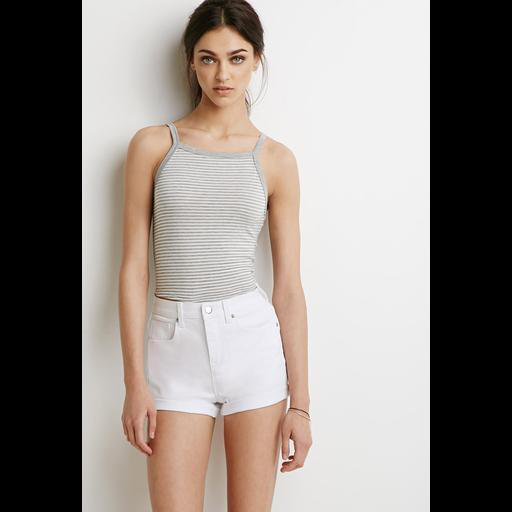

In [ ]:
# important to use imagenet[0]['image'] rather than imagenet['image'][0]
# as the latter loads the entire image column then extracts index 0
# whereas the former extracts record 0 and then retrieves the ['image']
dataset[0]['images']

In [ ]:
import numpy as np

img = np.array(dataset[0]['images'])
img.shape

(512, 512, 3)

In [ ]:
dataset[0]['images'].mode

'RGB'

We need to use these images to create vector embeddings, to do this we will use OpenAI's CLIP from the `transformers` library.

```
!pip install transformers
```

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

Now we're ready to use the resnet-50 portion of CLIP to create feature vectors (embedding representations) from the image.

In [ ]:
image = processor(
    text=None,
    images=dataset[0]['images'],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)

# image = processor(
#     text=dataset[0]['caption'],
#     images=dataset[0]['images'],
#     return_tensors='pt',
#     padding=True
# )['pixel_values'].to(device)

In [ ]:
out = model.get_image_features(pixel_values=image)
out.shape

torch.Size([1, 512])

In [ ]:
out = out.squeeze(0)
out.shape

torch.Size([512])

In [ ]:
emb = out.cpu().detach().numpy()
emb.shape

(512,)

In [ ]:
emb.min(), emb.max()

(-6.42829, 2.008049)

Now we have a single `512` dimensional vector that represents the *meaning* behind the image. As we will be using dot product similarity we should also normalize these vectors.

In [ ]:
emb = emb / np.linalg.norm(emb)

In [ ]:
emb.min(), emb.max()

(-0.5956763, 0.1860755)

## Indexing

To index this image in Pinecone we first install the Pinecone client:

```
!pip install pinecone-client
```

And then initialize our connection to Pinecone, this requires a [free API key](https://app.pinecone.io/).

In [ ]:
import pinecone

index_name = "imagenet-query-trainer-clip"

pinecone.init(
    api_key="86e95ed5-3633-498c-b63e-23cc09828cca",
    environment="northamerica-northeast1-gcp"
)

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        emb.shape[0],
        metric="dotproduct",
        metadata_config={"indexed": ["seen"]}
    )
# connect to the index
index = pinecone.Index(index_name)

To upsert the single feature embedding we have created, we use `upsert`:

In [ ]:
to_upsert = [("0", emb.tolist())]

index.upsert(to_upsert)

{'upserted_count': 1}

Note that we added a string ID value `"0"` and also converted the feature embedding tensor to a flat list before adding to our Pinecone index.

## Indexing Everything

So far we've built one feature embedding and indexed it in Pinecone, now let's repeat the process for a lot of images.

We will do this in batches, taking `32` images at a time, embedding them with Resnet-50, and indexing them in Pinecone.

In [ ]:
from tqdm.auto import tqdm
batch_size = 64

for i in tqdm(range(0, len(dataset), batch_size)):
    # select the batch start and end
    i_end = min(i + batch_size, len(dataset))
    # some images are grayscale (mode=='L') we only keep 'RGB' images
    images = [img for img in dataset[i:i_end]['images'] if img.mode == 'RGB']
    # process images and extract pytorch tensor pixel values
    image = processor(
        text=None,
        images=images,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # feed tensors to model and extract last state
    out = model.get_image_features(pixel_values=image)
    out = out.squeeze(0)
    # convert to a numpy array
    embeds = out.cpu().detach().numpy()
    # normalize and convert to list
    embeds = embeds / np.linalg.norm(embeds, axis=0)
    embeds = embeds.tolist()
    # create ID values
    ids = [str(i) for i in range(i, i_end)]
    # prep metadata
    meta = [{'seen': 0} for image in images]
    # zip all data together and upsert
    to_upsert = zip(ids, embeds, meta)
    index.upsert(to_upsert)

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save embeddings
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump(embeds, "/content/drive/MyDrive/Colab Notebooks/clip-embeddings.pkl", compress=3)

['/content/drive/MyDrive/Colab Notebooks/clip-embeddings.pkl']

We can now query given an image, like this of a radio:

In [ ]:
image = processor(
    text=None,
    images=[dataset[0]['images']],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)
out = model.get_image_features(pixel_values=image)
out = out.squeeze(0)
xq = out.cpu().detach().numpy()
# normalize
xq = xq / np.linalg.norm(xq)
xq = xq.tolist()

res = index.query(xq, top_k=5)

In [ ]:
res

{'matches': [{'id': '19984', 'score': 2.01450634, 'values': []},
             {'id': '19996', 'score': 1.96417975, 'values': []},
             {'id': '0', 'score': 1.89634836, 'values': []},
             {'id': '19997', 'score': 1.8824017, 'values': []},
             {'id': '19982', 'score': 1.75098753, 'values': []}],
 'namespace': ''}

In [ ]:
query_image = dataset[5802]['images'] # Your query image

In [ ]:
k = 5  # Number of retrieved images to display

def get_result(query,k):
  image = processor(
      text=None,
      images=[query_image],
      return_tensors='pt',
      padding=True
  )['pixel_values'].to(device)
  out = model.get_image_features(pixel_values=image)
  out = out.squeeze(0)
  xq = out.cpu().detach().numpy()
  # normalize
  xq = xq / np.linalg.norm(xq)
  xq = xq.tolist()

  res = index.query(xq, top_k=k)
  return res

res = get_result(query=query_image, k=k)

In [ ]:
import matplotlib.pyplot as plt

def plot_images(query_image, retrieved_images, scores, k):
    # Create a subplot grid with k+1 rows and 1 column
    fig, axes = plt.subplots(1, k+1, figsize=(12, 12))

    # Plot the query image in the first subplot
    axes[0].imshow(query_image)
    axes[0].axis('off')
    axes[0].set_title('Query Image', color='red')

    # Plot the retrieved images in the remaining subplots
    for i in range(k):
        axes[i+1].imshow(retrieved_images[i])
        axes[i+1].axis('off')
        axes[i+1].set_title(f'{scores[i]}', color = 'green')

    plt.tight_layout()
    plt.show()

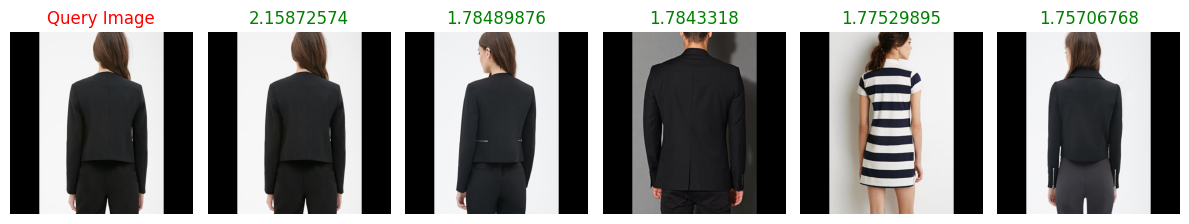

In [ ]:
matches = [dataset[int(match['id'])]['images'] for match in res['matches']]
scores = [match['score'] for match in res['matches']]
plot_images(query_image, matches, scores, k)

These results are excellent and show that our embedding and indexing is working as expected.

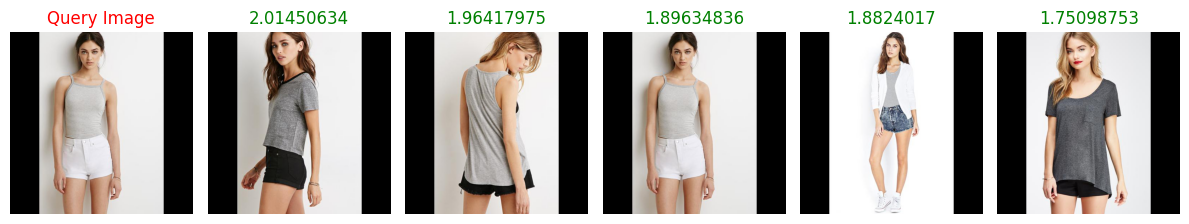

In [ ]:
query_image = dataset[0]['images']
res = get_result(query=query_image, k=k)
matches = [dataset[int(match['id'])]['images'] for match in res['matches']]
scores = [match['score'] for match in res['matches']]
plot_images(query_image, matches, scores, k)

In [ ]:
# ids = np.argsort(dists)[:30]
# scores = [(dists[id], img_paths[id]) for id in ids]

# # Visualize the result
# axes=[]
# fig=plt.figure(figsize=(8,8))
# for a in range(5*6):
#     # score = scores[a]
#     axes.append(fig.add_subplot(5, 6, a+1))
#     subplot_title=str(score[0])
#     # axes[-1].set_title(subplot_title)
#     plt.axis('off')
#     plt.imshow(Image.open(score[1]))
# fig.tight_layout()
# plt.show()

---